# Experiment on finance data

Dataset used is the currency enchange with respect to USD dollars, from daily measurements from the last 2 years (2017-2018).

Currencies used: 
- Reference: USA
- Canadian dollar (CAD)
- Euro (EUR)
- Japanese yen (JPY)
- Great british pound (GBP)
- Swiss franc (CHF)
- Austrial dollar (AUD)
- Hong Kong dollar (HKD)
- New zealand dollar (NZD)
- South korean won (KRW)
- Mexican peso (MXN)


**Question** how to treat sampling values when input is not time

---

Inflation data 
https://data.oecd.org/price/inflation-cpi.htm

In [16]:
# execute if not installed
import sys
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [17]:
# plot config
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

## Load dataset

In [3]:
df = pd.read_csv('data/finance_datasets/currency_exchange/final_dataset.csv')
cols = list(df)[3:]
cols[0], cols[1] = cols[1], cols[0]
cols

['EUR/USD',
 'CAD/USD',
 'JPY/USD',
 'GBP/USD',
 'CHF/USD',
 'AUD/USD',
 'HKD/USD',
 'NZD/USD',
 'KRW/USD',
 'MXN/USD']

In [4]:
data = []
for c in cols:
    data.append(mogptk.LoadCSV('data/finance_datasets/currency_exchange/final_dataset.csv',
                               x_cols='Day',
                               y_col=c,
                               name=c))
for d in data:
    d.transform(mogptk.TransformDetrend)

## Create and fit model

Remove data to simulate sensor failure

In [5]:
# randomly sample from the data
for channel in data:
    channel.remove_randomly(pct=0.3)

# drop chunks to simulate sensor failure

data[0].remove_range(df['Day'].iloc[-1], None)
data[1].remove_range(90, 120)
data[2].remove_range(480, 520)
data[3].remove_range(200, 250)
data[4].remove_range(None, 30)
data[5].remove_range(None, 30)
data[7].remove_range(500, 550)

for i in range(1, len(cols)):
     data[i].remove_range(680, None)

# add pred values

# use data class
x_test = [channel.X[~channel.mask] for channel in data]
y_test = [df[cols[i]].values[~data[i].mask] for i in range(len(cols))]

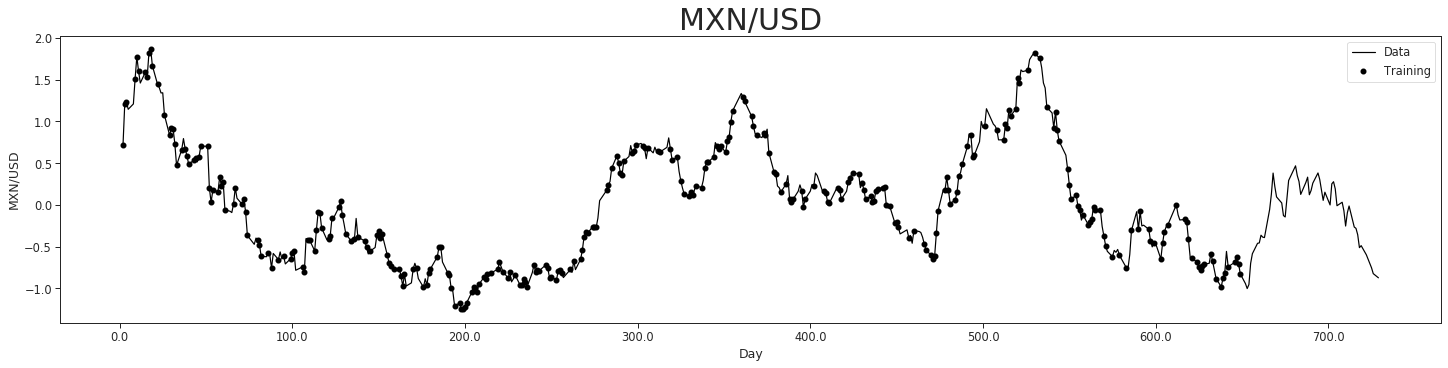

In [6]:
i = 9
data[i].plot()

## MOSM

warning!!!, long time of execution

In [8]:
%%time
n_trials = 5

mosm_list = []
mosm_mae = np.zeros((n_trials, len(cols)))
mosm_mape = np.zeros((n_trials, len(cols)))
mosm_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    model_mosm = mogptk.MOSM(data, Q=5)
    model_mosm.init_params('BNSE')
    
    print('Starting trial', n)
    model_mosm.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
    print('Finished trial', n)
    print('='*50)        
    
    mosm_list.append(model_mosm)
    
    # errors per channel
    error = mogptk.test_errors(model_mosm, x_test=x_test, y_test=y_test)
    
    mosm_mae[n, :] = np.array(error[0])[:, 0]
    mosm_mape[n, :] = np.array(error[0])[:, 1]
    mosm_rmse[n, :] = np.array(error[0])[:, 2]
    
pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_mape.mean(0), mosm_rmse.mean(0),
                             mosm_mae.std(0), mosm_mape.std(0), mosm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

Starting trial 0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -7350.768834
  Number of iterations: 5000
  Number of functions evaluations: 5361
Done in  126.32837406396865  minutes
Finished trial 0
Starting trial 1
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -7328.487938
  Number of iterations: 5000
  Number of functions evaluations: 5326
Done in  125.75585378408432  minutes
Finished trial 1
Starting trial 2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -7340.534795
  Number of iterations: 5000
  Number of functions evaluations: 5434
Done in  128.2099286198616  minutes
Finished trial 2
Starting trial 3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function valu

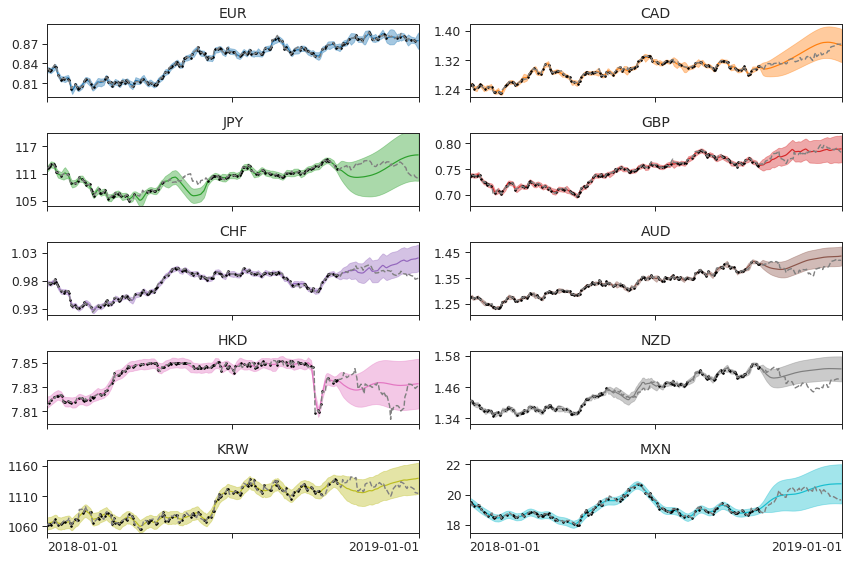

In [88]:
best_model = mosm_list[np.argmin(mosm_mape.mean(1))]

ylims = [(0.79, .9), (1.22, 1.42),
         (104, 120), (0.68, 0.82),
         (0.92, 1.05), (1.21, 1.49),
         (7.8, 7.86), (1.32, 1.6),
         (1050, 1170), (17.5, 22.3)]
f, axarr = mogptk.plot_prediction(best_model,
                       grid=(5, 2),
                       names=cols,
                       title='',
                       ylims=ylims,
                       figsize=(12, 8));

yticks = [(0.81, 0.87), (1.24, 1.4),
          (105, 117), (0.7, 0.8),
          (0.93, 1.03), (1.25, 1.45),
          (7.81, 7.85), (1.34, 1.58),
          (1060, 1160), (18, 22)]

for i in range(len(cols)):
    axarr[i].set_title(cols[i], fontsize=14)
    axarr[i].set_yticks(np.linspace(yticks[i][0], yticks[i][1], 3))

    channel = best_model.data[i]

    # xlabels = pd.date_range(df['Unnamed: 0'].iloc[0], df['Unnamed: 0'].iloc[-1], periods=9).date
    # xticks = [formatter._parse(str(label)) for label in xlabels]
    
    xlabels = pd.date_range('2017-01-01', '2019-01-01', periods=5)
    xticks = (xlabels - np.datetime64('2017-01-01')).days.values
    
    
    new_xlabels = xlabels.date
    new_xlabels[1::2] = ['']*2
    # xlabels[::2][2:] += datetime.timedelta(days=1)
    # new_xlabels[::2] = xlabels[::2]
    
    axarr[i].set_xticks(xticks)
    if i>= 8:
        axarr[i].set_xticklabels(new_xlabels)
    else:
        axarr[i].set_xticklabels([])

    axarr[i].set_xlim(xticks[2], xticks[-1])
    
    xlabel_list = [item for item in axarr[i].get_xticklabels()]
    if i>=8:
        xlabel_list[2].set_ha('left')
        xlabel_list[-1].set_ha('right')
plt.tight_layout()

plt.savefig('output/mosm_exchange_rate.pdf', bbox_inches='tight')

In [95]:
model_mosm.get_cross_params()['delay'][:, :, 0, :].max()

1.295634120876961

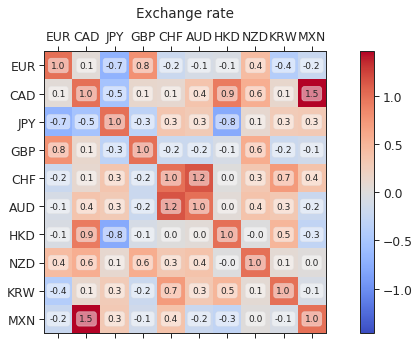

In [91]:
f, ax, corr_matrix = best_model.plot_correlations(9)
ax.set_title('Exchange rate', pad=20)
ax.set_yticks(np.arange(10));
ax.set_yticklabels(cols);
ax.set_xticks(np.arange(10));
ax.set_xticklabels(cols);
plt.tight_layout()

plt.savefig('output/corr_currency.pdf', bbox_inches='tight')

## CSM

In [ ]:
%%time
n_trials = 5

csm_mae = np.zeros((n_trials, len(cols)))
csm_mape = np.zeros((n_trials, len(cols)))
csm_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    model_csm = mogptk.CSM(data, Q=5)
    model_csm.init_params('BNSE')
    
    print('Starting trial', n)
    model_csm.train(method='L-BFGS-B', maxiter=5000, tol=1e-15)
    print('Finished trial', n)
    print('='*50)
    
    # errors per channel
    error = mogptk.test_errors(model_csm, x_test=x_test, y_test=y_test)
    
    csm_mae[n, :] = np.array(error[0])[:, 0]
    csm_mape[n, :] = np.array(error[0])[:, 1]
    csm_rmse[n, :] = np.array(error[0])[:, 2]

pd.DataFrame(np.c_[csm_mae.mean(0), csm_mape.mean(0), csm_rmse.mean(0),
                             csm_mae.std(0), csm_mape.std(0), csm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

In [ ]:
mogptk.plot_prediction(model_csm, grid=(5, 2), names=cols, title='Exchange prices CSM');

## SM-LMC

In [ ]:
n_trials = 5

smlmc_mae = np.zeros((n_trials, len(cols)))
smlmc_mape = np.zeros((n_trials, len(cols)))
smlmc_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model_smlmc = mogptk.SM_LMC(data, Q=5)
    model_smlmc.init_params('BNSE')
    
    model_smlmc.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
    
    error = mogptk.test_errors(model_smlmc, x_test=x_test, y_test=y_test)
    
    smlmc_mae[n, :] = np.array(error[0])[:, 0]
    smlmc_mape[n, :] = np.array(error[0])[:, 1]
    smlmc_rmse[n, :] = np.array(error[0])[:, 2]

pd.DataFrame(np.c_[smlmc_mae.mean(0), smlmc_mape.mean(0), smlmc_rmse.mean(0),
                   smlmc_mae.std(0), smlmc_mape.std(0), smlmc_rmse.std(0)],
             columns=['MAE', 'MAPE%', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

In [ ]:
mogptk.plot_prediction(model_smlmc, grid=(5, 2), names=cols, title='Exchange prices SM-LMC');

## IGP
Independant gaussian process with spectral mixture kernel

In [ ]:
%%time
n_trials = 5

igp_mae = np.zeros((n_trials, len(cols)))
igp_mape = np.zeros((n_trials, len(cols)))
igp_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    
    igp_list = []
    
    for i in range(len(cols)):
        model_sm = mogptk.SM(data[i], Q=3)
        model_sm.init_params('BNSE')
        model_sm.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
        
        igp_list.append(model_sm)
        
        error = mogptk.test_errors(model_sm, x_test=[x_test[i]], y_test=[y_test[i]])
    
        igp_mae[n, i] = np.array(error[0])[:, 0]
        igp_mape[n, i] = np.array(error[0])[:, 1]
        igp_rmse[n, i] = np.array(error[0])[:, 2]
    print('='*50)

In [ ]:
f, axarr = plt.subplots(5, 2, sharex=True, figsize=(12, 8))
axarr = axarr.reshape(-1)

for i in range(len(cols)):
    c = igp_list[i].data[0]
    x_train = c.X[c.mask]
    y_train = mogptk.data._detransform(c.transformations, c.X[c.mask], c.Y[c.mask])
    
    x_all = c.X
    y_all = mogptk.data._detransform(c.transformations, c.X, c.Y)
    
    x_pred = c.X
    mean_pred, lower_ci, upper_ci = igp_list[i].predict([x_pred])
    
    axarr[i].plot(x_train[:, 0], y_train, '.k', label='Train', )
    axarr[i].plot(x_all[:, 0], y_all, '--', label='Test', c='gray')

    axarr[i].plot(x_pred[:, 0], mean_pred[0], label='Post.Mean', c=sns.color_palette()[i%10])
    axarr[i].fill_between(x_pred[:, 0].reshape(-1),
                          lower_ci[0],
                          upper_ci[0],
                          label='95% c.i',
                          color=sns.color_palette()[i%10],
                          alpha=0.4)

    # axarr[i].legend(ncol=4, loc='upper center', fontsize=8)
    axarr[i].set_xlim(x_all[0]-1, x_all[-1])

    # set channels name
    
    axarr[i].set_title(cols[i])

plt.suptitle('IGP', y=1.02)
plt.tight_layout()

## Compare All

In [ ]:
print(mosm_mae[:, 1:].mean(), csm_mae[:, 1:].mean(), smlmc_mae[:, 1:].mean(), igp_mae[:, 1:].mean())

In [ ]:
print(mosm_mape[:, 1:].mean(), csm_mape[:, 1:].mean(), smlmc_mape[:, 1:].mean(), igp_mape[:, 1:].mean())

In [ ]:
print(mosm_mape[:, 1:].std(), csm_mape[:, 1:].std(), smlmc_mape[:, 1:].std(), igp_mape[:, 1:].std())

In [ ]:
print(mosm_rmse[:, 1:].mean(), csm_rmse[:, 1:].mean(), smlmc_rmse[:, 1:].mean())